# Tandem repeats in variation clusters

## Authors

- Egor Dolzhenko, PacBio
- Ben Weisburd, Broad Institute

In [27]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [16.5, 5]
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype'] = 42

## Introduction

Tandem repeats are regions of the genome that consist of consecutive copies of some motif sequence. For example, CAGCAGCAG is a tandem repeats with motif CAG. Tandem repeats (TRs) can be broadly separated into (a) isolated TRs and (b) TRs in variation clusters (VCs). This notebook notebook describes how to perform this analysis.

## Prerequisites

To prepare for this analysis, do the following:

- Obtain between 20 and 100 PacBio HiFi WGS BAMs (for example, see https://registry.opendata.aws/hpgp-data/)
- Install `vclust` tool (https://github.com/PacificBiosciences/vclust)
- Install the latest version of bedtools: https://bedtools.readthedocs.io/en/latest/

## Step 1: Annotate tandem repeats genome wide (or in the region of interest)

The analysis steps are outlined in [a blog post here](https://bw2.github.io/2023-11-12-defining-genome-wide-TR-catalogs.html) (see the technical details section). You must convert the TRs annotations into BED file containing coordinates of each TR region and its motifs (column 4) as shown in the example below. Let's assume that this file is called `tr_annotations.bed`.

```bash
chr1    3815768 3815780 ACCTCC
chr1    3815914 3815924 CTGC
chr1    3817343 3817353 AAAC
chr1    3817443 3817456 CTCTCA
chr1    3817512 3817530 CAGCCC,CCCAG
chr1    3817664 3817720 TCCCCC,CCTC
chr1    3817789 3817817 GACAGTGGCA,GGCAG
chr1    3818860 3818871 AATTG
```

## Step 2: Extend the boundaries of each repeat in your catalog

You are now ready to run the `vclust` tool. It will extend each region in your catalog to incorporate
variation that it identifies around the TR in your HiFi BAM files:

```bash
./vclust --genome genome.fa --reads bams/*.bam --regions raw_trs.bed > extended_trs.txt
```

where `genome.fa` is the reference genome, `bams/*.bam` are the HiFi BAMs you wish to analyze, `raw_trs.bed` is your repeat catalog from the previous step, and finally `extended_trs.txt` is the output file with information about the extension of each region based on the surrounding variation. Note that `vclust` is a single-threaded application and can be slow to run on large repeat catalogs. To speed up execution, you can split the input file into multiple pieces, analyze each one separately, and them merge the results.

Now you can convert the output of `vlust` command into a BED file.

In [24]:
%%bash

grep -v "NA" extended_trs.txt | awk '$3 > 5 || $4 > 5' \
    | awk '{OFS="\t"; print $5, $1}' | awk -F "[\t:-]" '{OFS="\t"; print $1, $2, $3, $0}' \
    | cut -f 1-3,5 | sort -k 1,1 -k 2,2n -k 3,3n | bedtools merge -d -1 -c 4 -o distinct \
    | awk '{OFS="\t"; print $1, $2, $3, "ID="$1"_"$2"_"$3";MOTIFS="$4";STRUC=<TR>"}' \
    > vcs.bed

In [25]:
! head vcs.bed

chr1	54712	54817	ID=chr1_54712_54817;MOTIFS=TTCT,TTTC;STRUC=<TR>
chr1	66160	66415	ID=chr1_66160_66415;MOTIFS=ATATA,TA,TATAT;STRUC=<TR>
chr1	83797	84052	ID=chr1_83797_84052;MOTIFS=AAAG,AAGC,AG,AGAA,GAAA;STRUC=<TR>
chr1	90258	90431	ID=chr1_90258_90431;MOTIFS=GTCCCTCTGTCTCTGCCAACCAGTTAACCTGCTGCTTCCTGGAGGAAGACAGTCCCTCT;STRUC=<TR>
chr1	98999	99116	ID=chr1_98999_99116;MOTIFS=T,TTTA;STRUC=<TR>
chr1	135166	135184	ID=chr1_135166_135184;MOTIFS=GAGGCC;STRUC=<TR>
chr1	136322	137049	ID=chr1_136322_137049;MOTIFS=CTGACCTCTCTCAGCGTGGGAGGGGCCGGTGTGAGGCAAGGGGCTCGGG,GCGTGGGAGGGGCCGGTGTGAGGCAAGGGGCTCAGGCTGACCTCTGTCC;STRUC=<TR>
chr1	143740	143763	ID=chr1_143740_143763;MOTIFS=TGC;STRUC=<TR>
chr1	146569	146584	ID=chr1_146569_146584;MOTIFS=TC;STRUC=<TR>
chr1	151295	151331	ID=chr1_151295_151331;MOTIFS=TTTC;STRUC=<TR>


## Step 3: Study some properties of variation clusters

You can summarize the lengths of the variation clusters as shown below. Note that because the tail of this distribution is so long, it is capped at 500 bp.

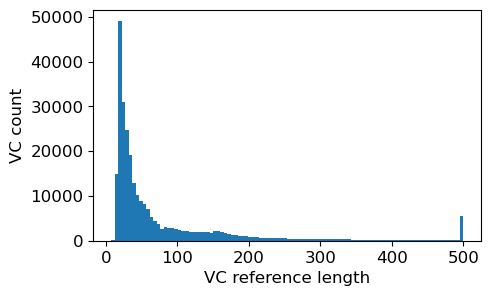

In [37]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))

lens = ! awk '{print $3 - $2}' vcs.bed
lens = [int(l) for l in lens]
lens = [min(l, 500) for l in lens]
ax.hist(lens, bins=100)
ax.set_xlabel("VC reference length")
ax.set_ylabel("VC count");